# [23차시] 프로젝트 7 : 2레이어 신경망 구현하기 (1)

우리는 대표적인 비선형 분류 문제인 XOR 문제를 풀기위해 2개의 히든 레이어 뉴럴네트워크를 만들것 입니다. 2레이어 뉴럴네트워크 모델은 딥러닝 라이브러리를 활용하면 너무나 간단하게 구성할 수 있겠지만 우리는 어렵게 Numpy로 구현할것 입니다. "왜 쉽게 해결할 수 있는 것을 어렵게 구현하나요?"와 같은 질문이 떠오릅니다. 거기에 대해서 전 TESLA AI팀 디렉터이자 OpenAI 설립자 중 한명인 안드레 카파시(Andrej karpathy)의 대답을 인용해 봅니다.
- [Yes, you should understand backprop](https://karpathy.medium.com/yes-you-should-understand-backprop-e2f06eab496b)

안드레 카파시 답변의 핵심은 실제로 역전파 과정을 구현해 봄으로써 뉴럴네트워크가 학습하는 경사하강법의 원리를 잘 이해할수 있게되고, 뉴럴네트워크를 어떤 구조로 만들어야 잘 동작하는지 알게 된다는것 입니다. 이제 어렵게 직접 구현해 볼 마음이 생기시나요? ^^
<br><br>
직접 역전파 과정을 구현해보는 것은 생각보다 쉽지않기 때문에 비교적 쉬운 문제에 적용해 보고 뉴럴네트워크가 비선형 문제를 풀 수 있음을 보이기 위해서 XOR 문제를 뉴럴네트워크로 풀어볼 것 입니다.

그럼 시작 합니다!!!

## XOR문제란?
XOR문제는 다음과 같습니다. 입력은 2개의 $x_1$, $x_2$에 해당하고 그 결과로는 $y$를 출력하는 논리회로 입니다. XOR연산은 eXclusion OR 의 줄임말이고, 출력의 특징은 두 입력이 같으면 0을, 다르면 1을 출력하는것 입니다. 아래의 표에서 입출력 구조를 확인하실 수 있습니다.

|($x_1$,$x_2$)|$y$|
|:---:|:---:|
|(0,0)|0|
|(0,1)|1|
|(1,0)|1|
|(1,1)|0|

이것을 그림으로 표현해 보면 아래와 같습니다. (0,1), (1,0)의 경우 'X'로 표현하였고, (0,0), (1,1)의 경우 "O'로 표현해 봤습니다. 그림을 보면 이 둘을 구분할 수 있는 직선이 존재하지 않는다는 것을 알 수 있습니다.

이 둘을 직선으로 구분하기 위해서는 적절한 입력공간의 변환이 필요하다는 것을 알수 있습니다. 2레이어 뉴럴네트워크는 선형으로 분리할 수 없는 XOR문제를 선형으로 풀수 있게 입력을 변환 시킬 것 입니다.

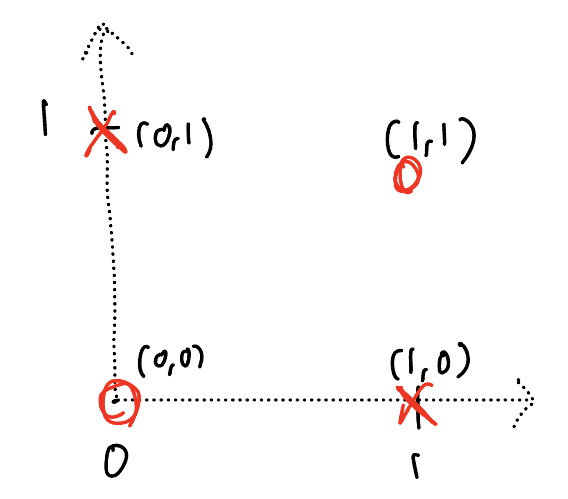

## 모델 세팅
입력 `X`와 정답 레이블인 `Y`를 아래의 코드를 이용하여 만들어 보겠습니다.

`X`는 2x4 형태이며 하나의 컬럼이 하나의 데이터를 의미합니다. 즉 입력이 2차원인 4개의 데이터가 있다는 뜻이죠. `Y`는 각 4개의 데이터에 대한 정답 레이블로 1x4입니다. XOR 게이트의 4개의 입력과 4개의 출력이 `X`, `Y`인거죠.

In [ ]:
import numpy as np # numpy import
X = np.array([0, 0, 1, 1, 0, 1, 0, 1]).reshape(2,4) # 입력
Y = np.array([0, 1, 1, 0]).reshape(1,4) # 정답

print(X)
print(Y)

**파라미터 세팅**

다음은 2레이어 뉴럴네트워크의 파라미터를 세팅할 차례입니다. 히든 레이어에 포함되는 유닛(뉴런)의 수는 2로 정하여 간단한 구조로 하겠습니다.

파라미터 세팅을 위해 함수 `init_parameters()`를 아래의 코드와 같이 만들었습니다. 이 함수는 첫번째 레이어의 가중치 매트릭스 $W^{[1]}$과 바이어스 $B^{[1]}$, 두번째 레이어의 가중치 매트릭스 $W^{[2]}$와 바이어스 $B^{[2]}$를 랜덤으로 초기화 합니다.

In [ ]:
# 가중치 초기화 함수
def init_parameters(num_hidden_units = 2):
  W1 = np.random.randn(2, num_hidden_units) # 첫번째 레이어 가중치
  B1 = np.zeros((num_hidden_units,1)) # 첫번째 레이어 바이어스
  W2 = np.random.randn(num_hidden_units, 1) # 두번째 레이어 가중치
  B2 = np.zeros((1, 1)) # 두번째 레이어의 바이어스
  return W1, B1, W2, B2 # 가중치 파라미터 리턴

### 포워딩 연산 : 어파인 변환(affine transform) 연산과 시그모이드 활성화 함수 만들기

하나의 레이어는 연속된 2가지 연산을 수행합니다.

1. 어파인 변환(affine transform): 가중치 매트릭스인 $W$를 곱하고(선형변환) 여기에 바이어스인 $B$를 더하는 연산입니다. 변환결과는 원점이 이동된(바이어스 덧셈연산으로 인해) 선형변환이라고 보시면 됩니다. 이를 어파인 변환이라고 합니다.

2. 비선형 활성화 함수  : 어파인 변환된 결과에 비선형 연산을 추가하게 됩니다. 어파인 변환으로는 XOR같은 직선으로 나눌 수 없는 분류 문제를 풀어내는데 한계가 있습니다. 비선형 변환을 통해 입력을 선형분리 가능한 형태로 변환 시켜줘야 합니다.

이 두개의 연산이 뉴럴네트워크 레이어 하나를 구성합니다. 레이어를 쌓게되면 어떻게 될까요? 계속 어파인 변환과 비선형 변환을 통해 복잡한 형태의 공간도 표현할 수 있게 될것 입니다.

이제 미션을 통해 어파인변환 함수와, 비선형 활성화 함수로 시그모이드 함수(sigmoid function)를 만들어 보겠습니다. 아래의 수식을 함수로 구현하시면 됩니다.

- 어파인 변환 함수 (Affine transform) : $W^T\cdot X + B$

- 시그모이드 함수 (sigmoid function) : $\sigma(z) = \frac{1}{1 + e^{-z}}$



In [ ]:
####################################################
######## 미션 코드 : 어파인함수와 시그모이드 함수 ###########
####################################################

# Affine transform을 구현하세요.
def affine(W, X, B):
  return ... # '...'에 코드를 채워주세요.

# sigmoid function을 구현하세요.
def sigmoid(z):
  return ... # '...'에 코드를 채워주세요.

여러분이 작성한 코드가 제대로 구현했는지 확인해 보기 위해서 다음의 테스트 코드를 수행해 보도록 하겠습니다.


In [ ]:
# 임의로 w, b, x를 만들고 affine 함수를 테스트 해봅니다
w = np.arange(4).reshape(2,2)
b = [[1],[2]]
x = [[1],[1]]

print(affine(w, x, b)) # affine test -> [[3],[6]]

print(sigmoid(0.1)) # sigmoide test -> 0.524979

주석에 나온 값이 나오신다면 옳게 구현하신 겁니다. 수고하셨습니다.

### 손실함수 만들기 : 이진 크로스 엔트로피 (Binary Cross Entropy)

모델을 학습시키기 위해선 모델이 출력하는 에측값과 실제 정답이 얼마나 차이가 있는지를 측정하는 손실함수(loss function)가 필요합니다. 그리고 함수 값을 줄이는 방향으로 파라미터를 업데이트 합니다.
우리는 미션을 통해 `0`과 `1`, 즉 2개의 부류를 구분할 때 사용하는 이진 크로스엔트로피(binary cross entropy) 손실함수를 구현할 것 입니다.  수식은 아래와 같습니다.

$$\text{Binary Cross Entropy}(y, \hat{y}) = -\frac{1}{N}\sum_{i=1}^n  (y_i \cdot \log(\hat{y_i}) + (1 - y_i) \cdot \log(1 - \hat{y_i}) )$$

- $y_i$ : $i$ 번째 정답 값 (0 or 1)
- $\hat{y_i}$ : $i$ 번재 추정 값 ($0<\hat{y}<1$)
- $\log$ : 자연로그
- $N$ : 샘플의 수

 이제부터 이 수식을 구현해 보시죠.

In [ ]:
###########################################
####### 미션 코드 : 이진 크로스 엔트로피  ########
###########################################
def binary_cross_entropy(Y, YHat):
  N = Y.shape[1] # 총 샘플의 수
  loss = ... # '...'에 코드를 채워주세요
  return loss

구현된 `binary_cross_entropy` 함수가 정확하게 구현됐는지 확인해 보기 위해 간단히 아래의 코드를 실행하여 값을 확인해보도록 하겠습니다.
테스트에서 정답인 `Y`값은 XOR의 값을 그대로 사용하고, 추정 값인 `YHat` 가상으로 만들어서 여러분이 만들어둔 `binary_cross_entropy`에 집어넣어 보겠습니다.

In [ ]:
# 정답 확인
Y = np.array([0, 1, 1, 0]).reshape(1, 4) # 정답
YHat = np.array([0.5, 0.5, 0.5, 0.5]).reshape(1, 4) # 추정값

loss = binary_cross_entropy(Y, YHat)
print("2진 크로스엔트로피 비용:", loss)

### 2레이어 뉴럴네트워크 순방향(forward)연산 구현하기
이제 여러분이 만들었던 `affine(W, X, B)`함수와 `sigmoid(z)`함수 그리고 `binary_cross_entropy(Y, YHat)`함수를 이용하여 2레이어 뉴럴네트워크의 순방향 연산 함수를 만들어 보겠습니다.


In [ ]:
########################################
####### 미션 코드 : 2레이어 순방향 연산 #######
########################################

def forward_loss(X, Y, _params):
  W1, B1, W2, B2 = _params

  # 첫번째 레이어연산
  Z1 = ... # 1) affine 함수  - '...'에 채워주세요
  H = ... # 2) sigmoid 함수 - '...'에 채워주세요

  # 두번째 레이어 연산
  Z2 = ... # 3) affine 함수 - '...'에 채워주세요
  YHat = ... # 4) sigmoid 함수  - '...'에 채워주세요

  # 손실함수 계산
  loss = ... # 5) 이진크로스 엔트로피 함수 - '...'에 채워주세요

  return Z1, H, Z2, YHat, loss

일반적으로 학습이 완료된 상태의 순방향 연산은 손실함수 값이 필요없기 때문에 이를 순방향 연산에 포함하지 않습니다. 여기서는 이해가 목적이니 구현의 편의를 위해 모두 집어 넣었습니다.

이제 샘플 데이터를 집어 넣어서 여러분이 구현한 순방향 연산이 잘 동작하는지 확인해 보겠습니다. 아래의 코드를 실행하여 loss값이 주석과 같이 나왔다면 옳게 구현했다고 볼 수 있습니다.

In [ ]:
np.random.seed(42) # random seed로 고정
W1, B1, W2, B2 = init_parameters(num_hidden_units = 2) # 파라미터 초기화
forward_loss(X, Y, [W1, B1, W2, B2])[-1] # loss출력 : 0.70492209

지금까지의 전체 순방향 과정을 그림으로 그려보면 아래와 같습니다. 그림은 최우성님이 작성해주신 [Multi-Layer Neural Network](https://ws-choi.github.io/blog-kor/deeplearning/Multi-Layer-Neural-Network/#)에서 가져왔습니다.

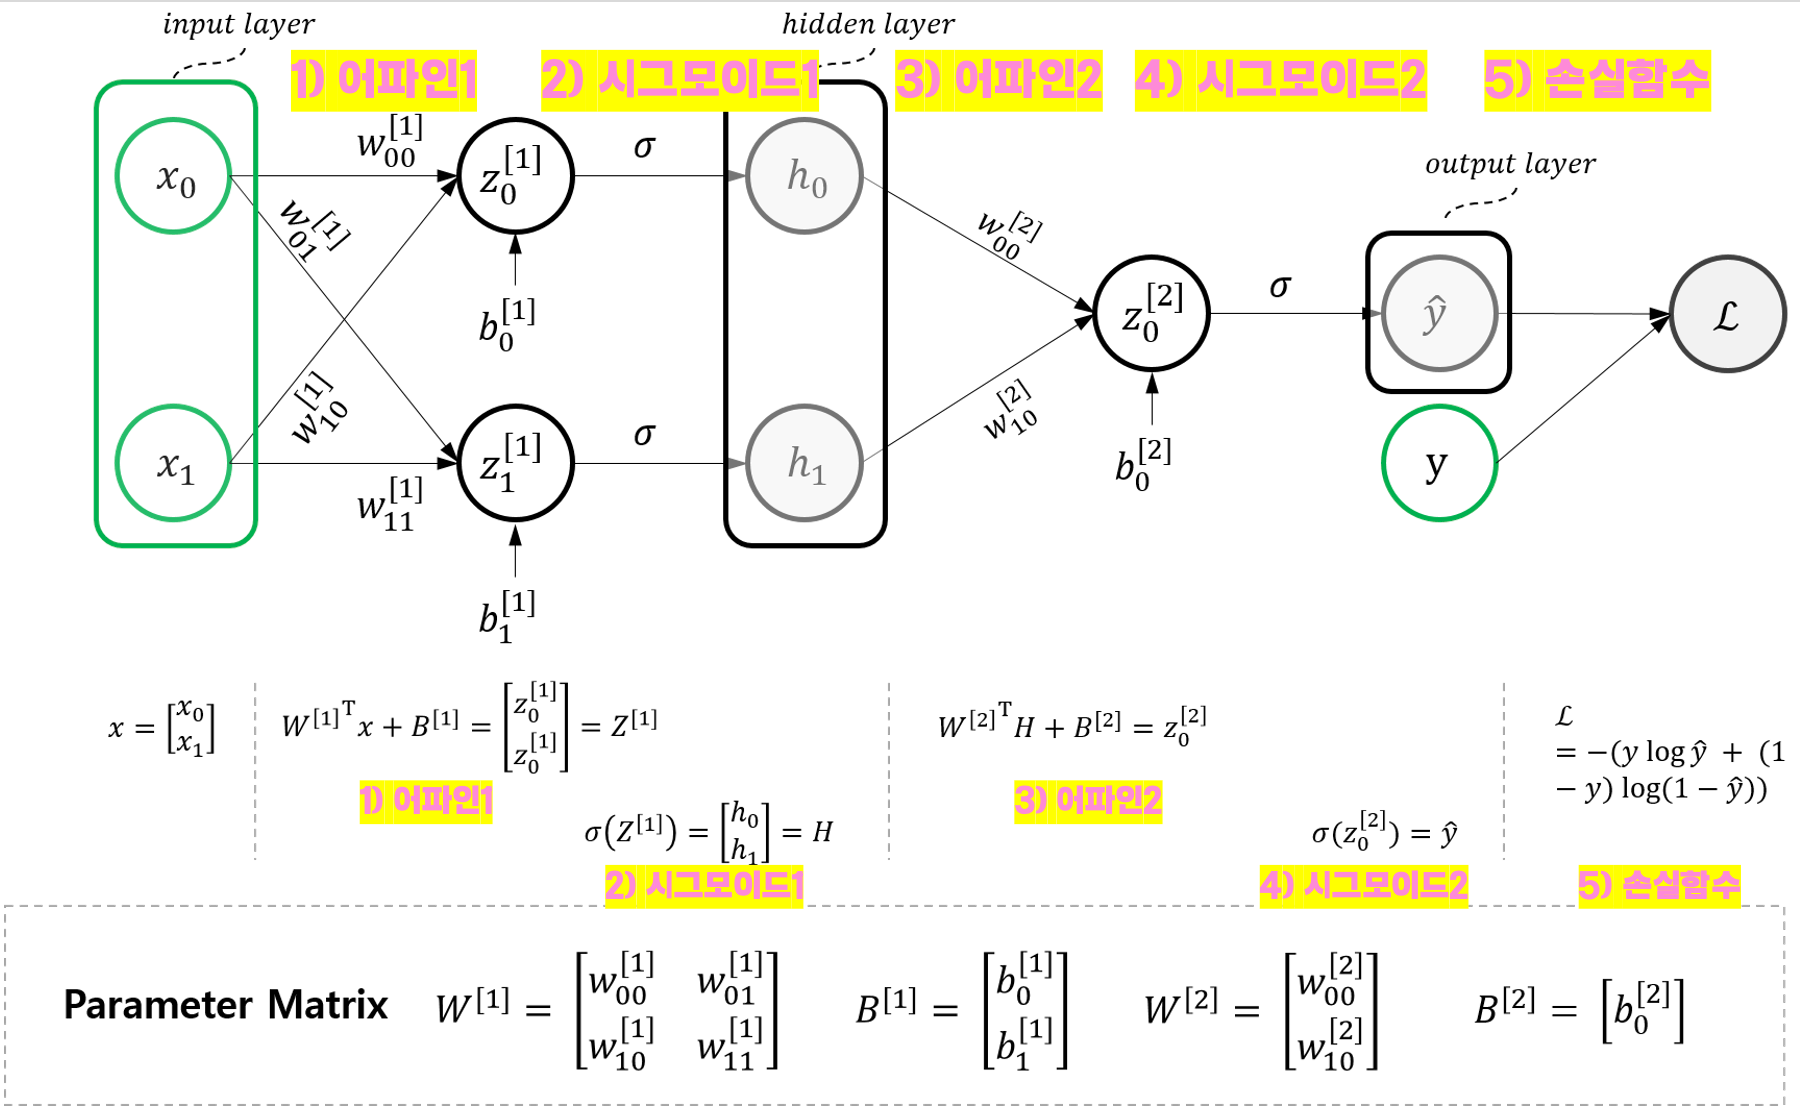

### 역방향(backward) 그레디언트 계산하기
이제 백워드 연산을 통해 뉴럴네트워크의 파라미터 업데이트를 수행할 차례입니다. 우리가 업데이트 해야할 파라미터는 첫번째 레이어의 `W1`, `B1`, 두번째 레이어의 `W2`, `B2` 입니다.
우리가 배웠던 경사하강법(gradient descent)의 수식ㅇㄹ 적용하면 다음과 같은 업데이트를 수행해야 합니다.

\begin{aligned}
W^{[1]} &\leftarrow W^{[1]} - \alpha \frac{\partial Loss}{\partial W^{[1]}}\
\end{aligned}

\begin{aligned}
B^{[1]} &\leftarrow B^{[1]} - \alpha \frac{\partial Loss}{\partial B^{[1]}}\
\end{aligned}

\begin{aligned}
W^{[2]} &\leftarrow W^{[2]} - \alpha \frac{\partial Loss}{\partial W^{[2]}}\
\end{aligned}

\begin{aligned}
B^{[2]} &\leftarrow B^{[2]} - \alpha \frac{\partial Loss}{\partial B^{[2]}}\
\end{aligned}

위 수식에서 $\alpha$는 학습율(learning rate)을 의미합니다.
경사하강법은 매우 간단한 수식이며 위 수식에서 구현이 까다로운 부분은 각 파라미터의 편미분 값인 $\frac{\partial Loss}{\partial W^{[1]}}$, $\frac{\partial Loss}{\partial B^{[1]}}$, $\frac{\partial Loss}{\partial W^{[2]}}$, $\frac{\partial Loss}{\partial B^{[2]}}$를 계산하는 것입니다.

이 까다로운 계산을 효과적으로 수행하는 방법이 역전파(backpropagation)방법입니다. 역전파 과정을 수식과 함께 이해해보도록 하겠습니다.

### 합성함수의 미분법인 체인 룰(chain rule) 적용 == 역전파 방법
우리가 구현했던 순방향 연산을 잘 살펴보시죠. 뉴럴네트워크의 입력부터 손실함수까지 계산하기 위해서 레이어를 쌓아 만들었고 각 레이어의 연산은 함수로 표현될 수 있었습니다. 즉, 깊은 레이어를 갖는 뉴럴네트워크는 많은 수의 함수를 연결한 합성함수로 표현될 수 있다는 것이죠.

합성함수를 미분하는 대표적인 방법은 체인룰(chain rule)을 적용하는 겁니다. 가장 바깥에 존재하는 함수인 `Loss`부터 시작하여 우리가 원하는 파라미터인 $W$와 $B$의 미분까지 체인룰을 적용하면 복잡한 함수의 미분도 단계적으로 풀어나갈 수 있습니다.

2레이어 뉴럴네트워크 손실함수를 파라미터로 편미분한 결과를 체인룰로 표현하면 다음과 같습니다. <br><br>

- $\frac{\partial Loss}{\partial W^{[2]}} = \frac{\partial Loss}{\partial \hat{y}}\cdot \frac{\partial \hat{y}}{\partial z^{[2]}}\cdot \frac{\partial z^{[2]}}{\partial W^{[2]}}$

- $\frac{\partial Loss}{\partial B^{[2]}} = \frac{\partial Loss}{\partial \hat{y}}\cdot \frac{\partial \hat{y}}{\partial z^{[2]}}\cdot \frac{\partial z^{[2]}}{\partial B^{[2]}}$

- $\frac{\partial Loss}{\partial W^{[1]}} = \frac{\partial Loss}{\partial \hat{y}}\cdot \frac{\partial \hat{y}}{\partial z^{[2]}}\cdot \frac{\partial z^{[2]}}{\partial H}\cdot \frac{\partial H}{\partial z^{[1]}}\cdot \frac{\partial  z^{[1]}}{\partial W^{[1]}}$

- $\frac{\partial Loss}{\partial B^{[1]}} = \frac{\partial Loss}{\partial \hat{y}}\cdot \frac{\partial \hat{y}}{\partial z^{[2]}}\cdot \frac{\partial z^{[2]}}{\partial H}\cdot \frac{\partial H}{\partial z^{[1]}}\cdot \frac{\partial  z^{[1]}}{\partial B^{[1]}}$

<br><br>
체인룰을 통해 `Loss`함수를 파라미터로 미분한 값을 얻는 과정은 맨 마지막 손실함수의 미분부터 시작하여 역순으로 각 레이어에 해당하는 함수의 미분 값을 곱해나가는 과정임을 알 수 있습니다.

위 수식을 역전파의 구현과정과 연결하여 살펴보겠습니다.

</br>

**1) 손실함수의 편미분 $\frac{\partial Loss}{\partial \hat{y}}$ 를 구합니다.**

이렇게 뒤로 전달되어 곱해져야 하는 편미분값을 Up-stream gradient로 부를것 입니다.
<br><br>

**2) 두번째 레이어의 시그모이드 편미분인 $\frac{\partial \hat{y}}{\partial z^{[2]}}$를 구합니다.**

이와 같이 각 레이어 함수에 해당하는 편미분 값을 Local gradient라고 부릅니다. <br><br>

**3) 이제 Up-stream gradient와 Local gradient를 곱하여 이를 다시 Up-stream gradient로 만듭니다.**

지금까지의 과정을 그림으로 표현하면 아래와 같습니다.




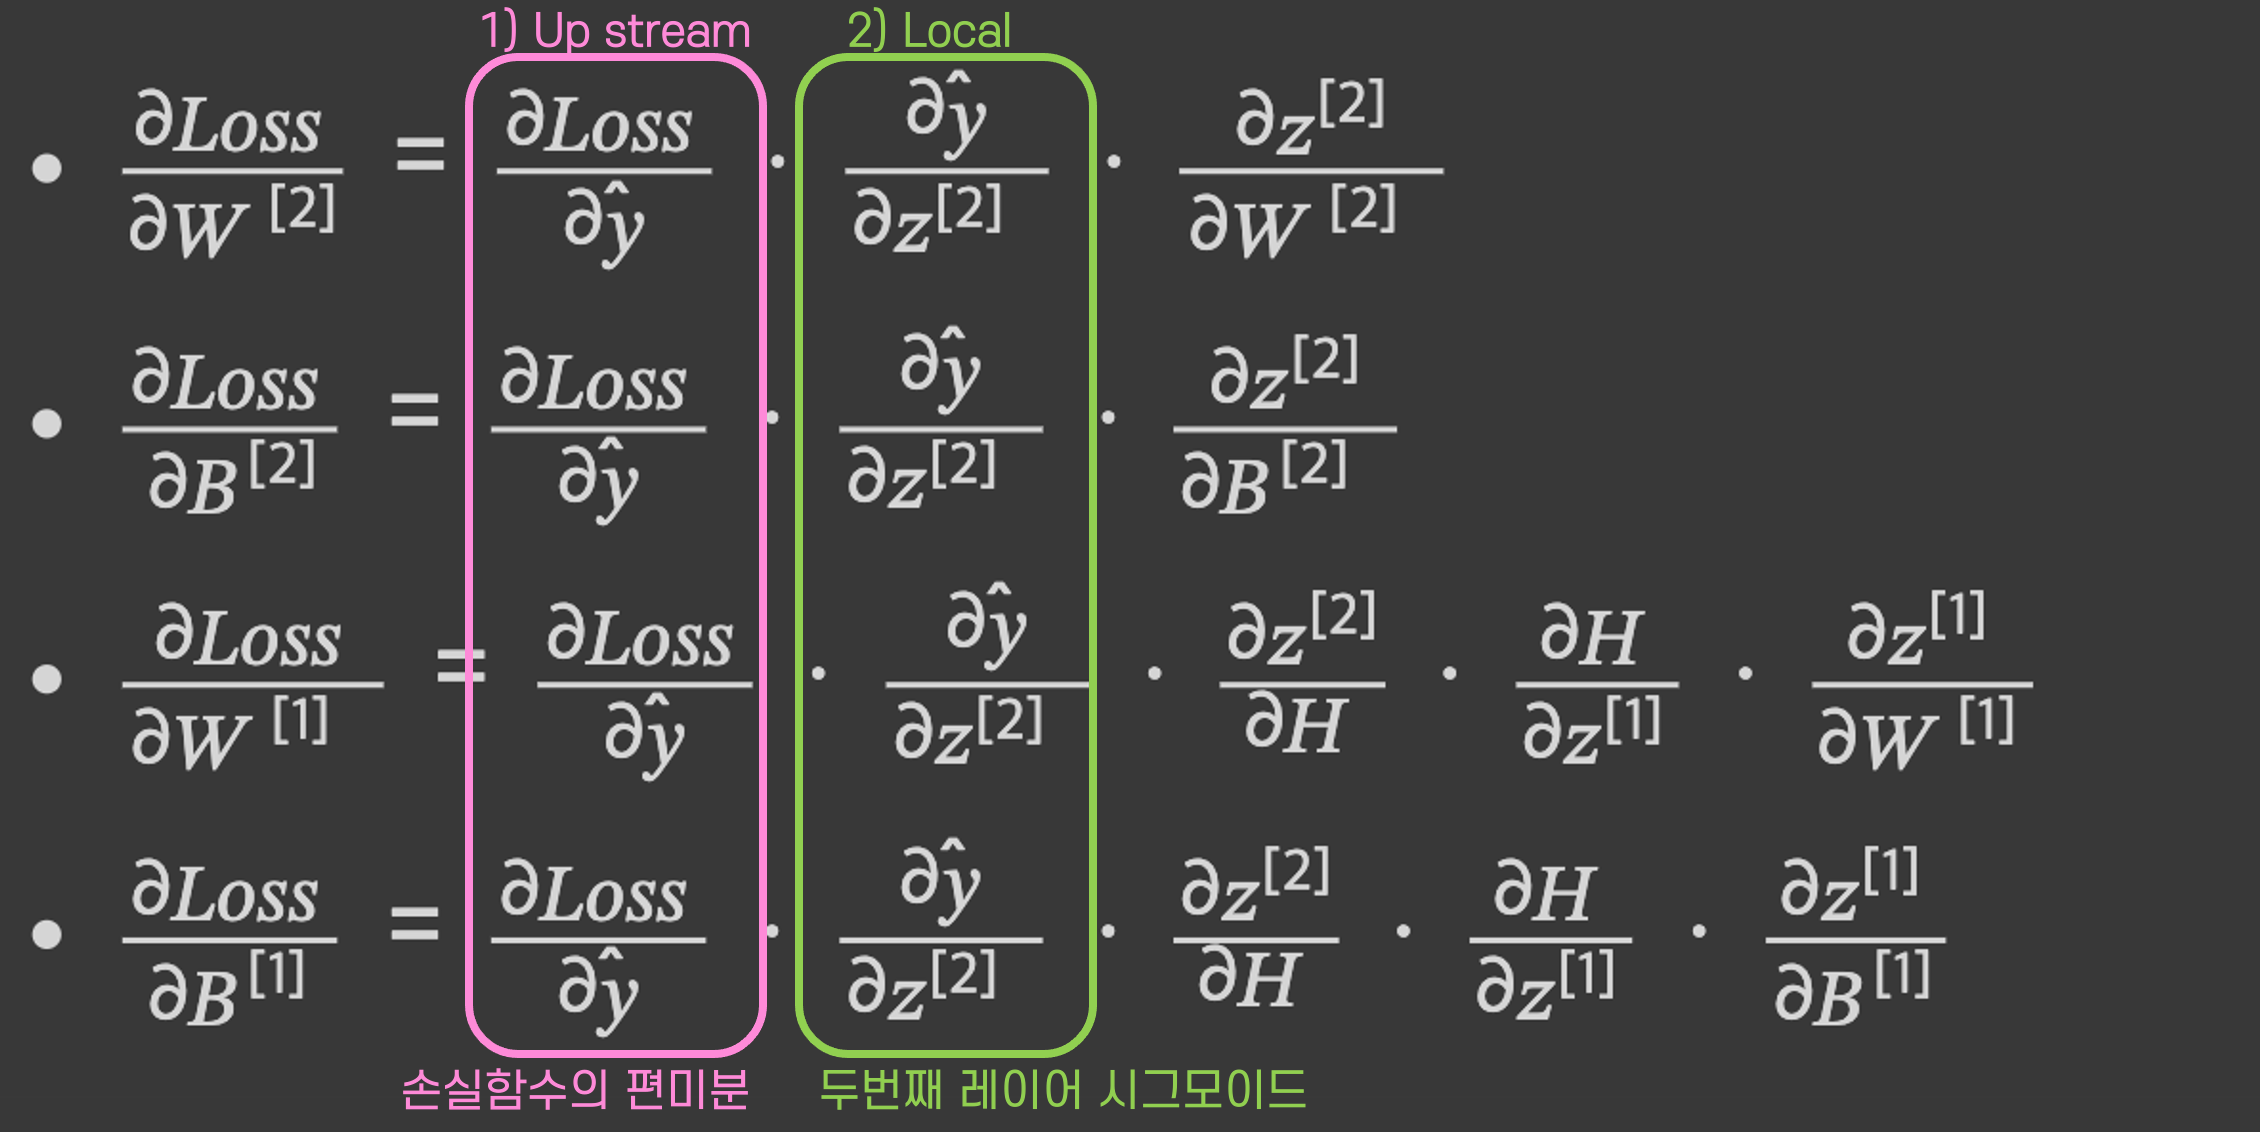

그림에서 손실함수의 편미분 `1)Up stream` gradient와 두번째 레이어 활성화 함수(시그모이드)의 편미분인 `2) Local` gradient를 곱하면 아래의 그림과 같은 `3)Up stream` gradient를 새롭게 만들 수 있습니다.

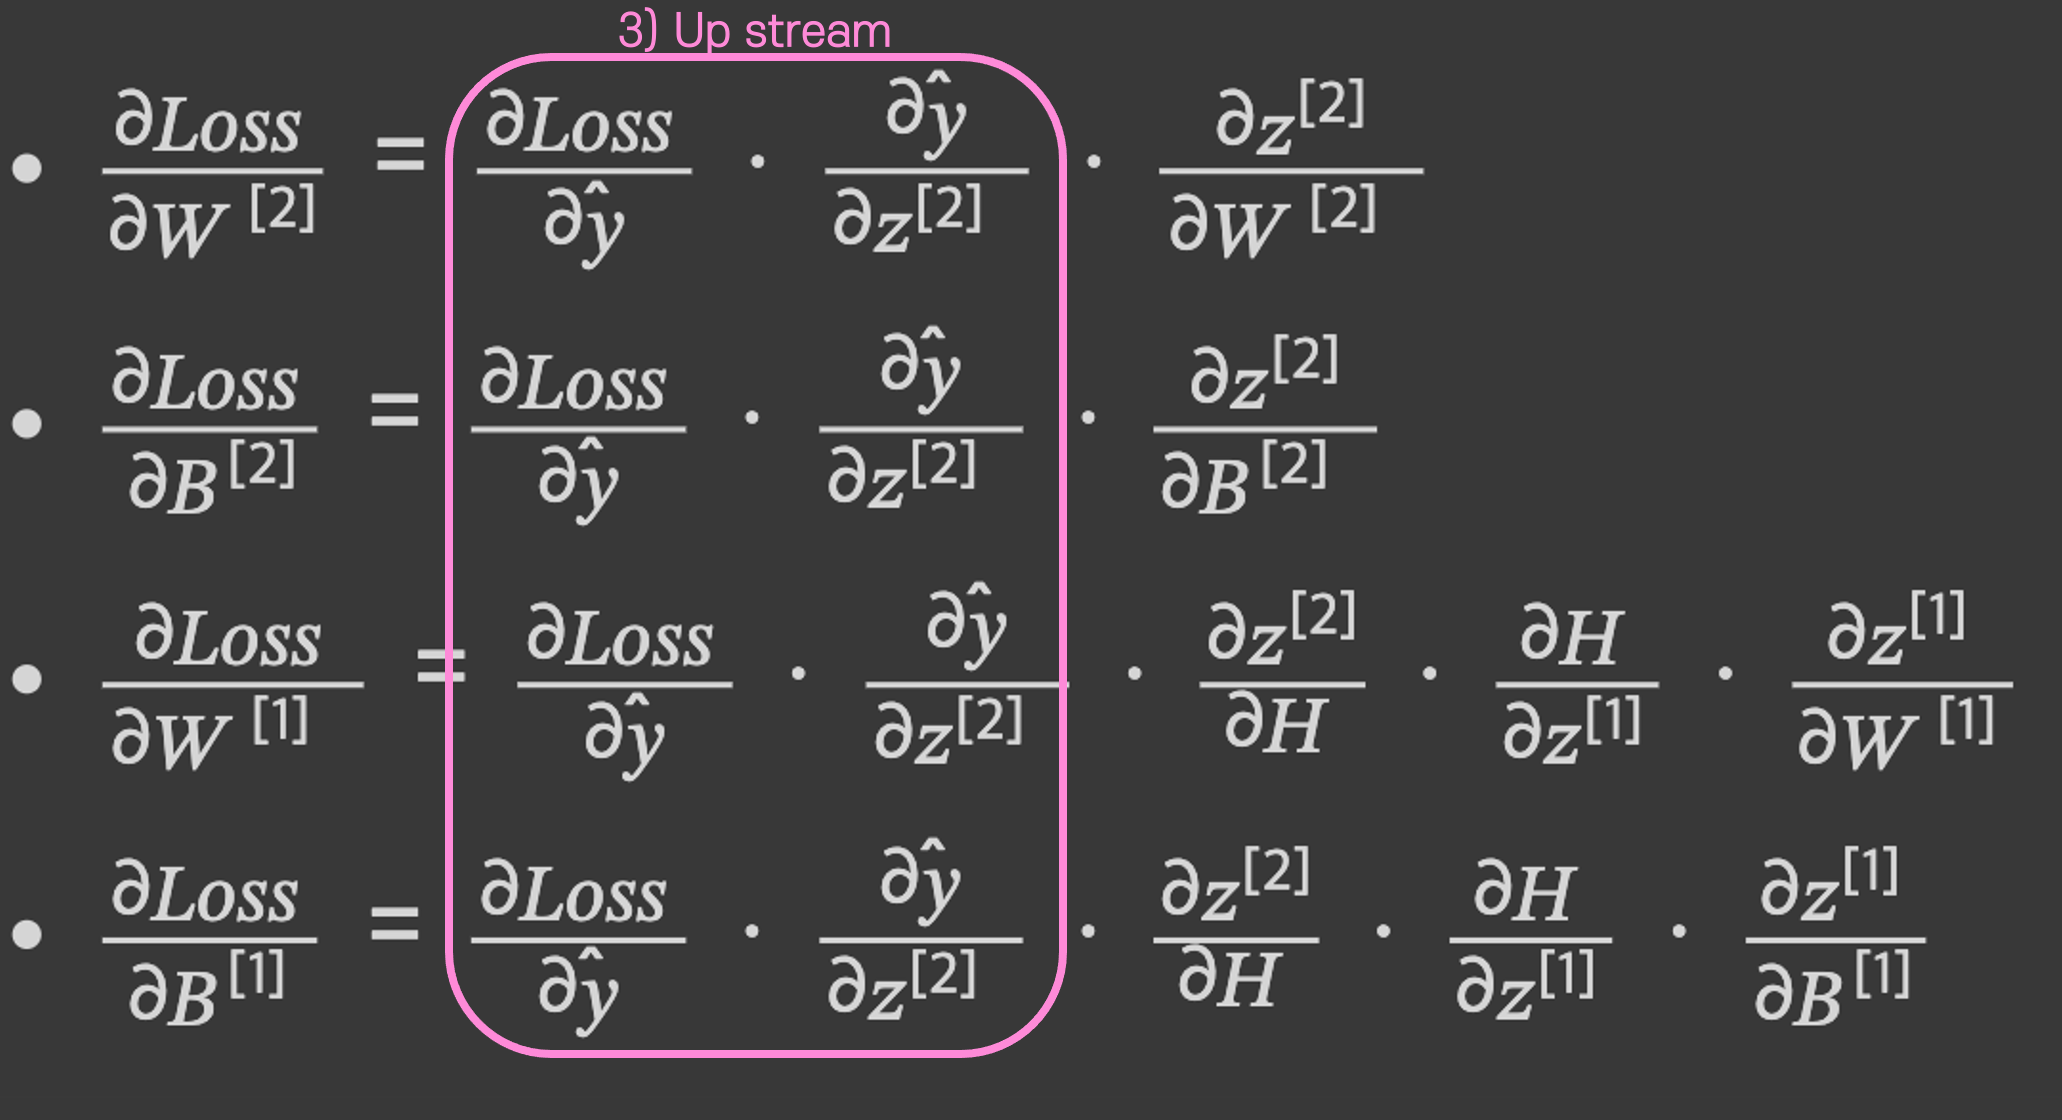

여기까지 계산하셨다면 두번째 레이어의 파라미터 편미분 $\frac{\partial Loss}{\partial W^{[2]}}$ 와 $\frac{\partial Loss}{\partial B^{[2]}}$는 쉽게 계산될수 있을겁니다. 이어서 첫번째 레이어의 파라미터 편미분 계산을 계속해 보겠습니다.  아래의 수식 그림을 참고해주세요. <br><br>

**4) 두번째 레이어 어파인함수의 `4)Local` gradient인 $\frac{\partial z^{[2]}}{\partial W^{[2]}}$를 계산한 후 `3)Up stream` gradient와 곱하여 $\frac{\partial Loss}{\partial W^{[2]}}$에 대한 편미분 계산을 완료합니다.** <br>

**5) 두번째 레이어 어파인함수의 `5)Local` gradient인 $\frac{\partial z^{[2]}}{\partial B^{[2]}}$를 계산한 후 `3)Up stream` gradient와 곱하여 $\frac{\partial Loss}{\partial B^{[2]}}$에 대한 편미분 계산을 완료합니다.** <br>

**6) 두번째 레이어 어파인함수의 `6)Local` gradient인 $\frac{\partial z^{[2]}}{\partial H}$를 계산한 후 `3)Up stream` gradient와 곱하여**

**7) 새로운 `7)Up stream` gradient를 만들고 체인룰을 이어나갈 준비를 합니다.**
<br><br>

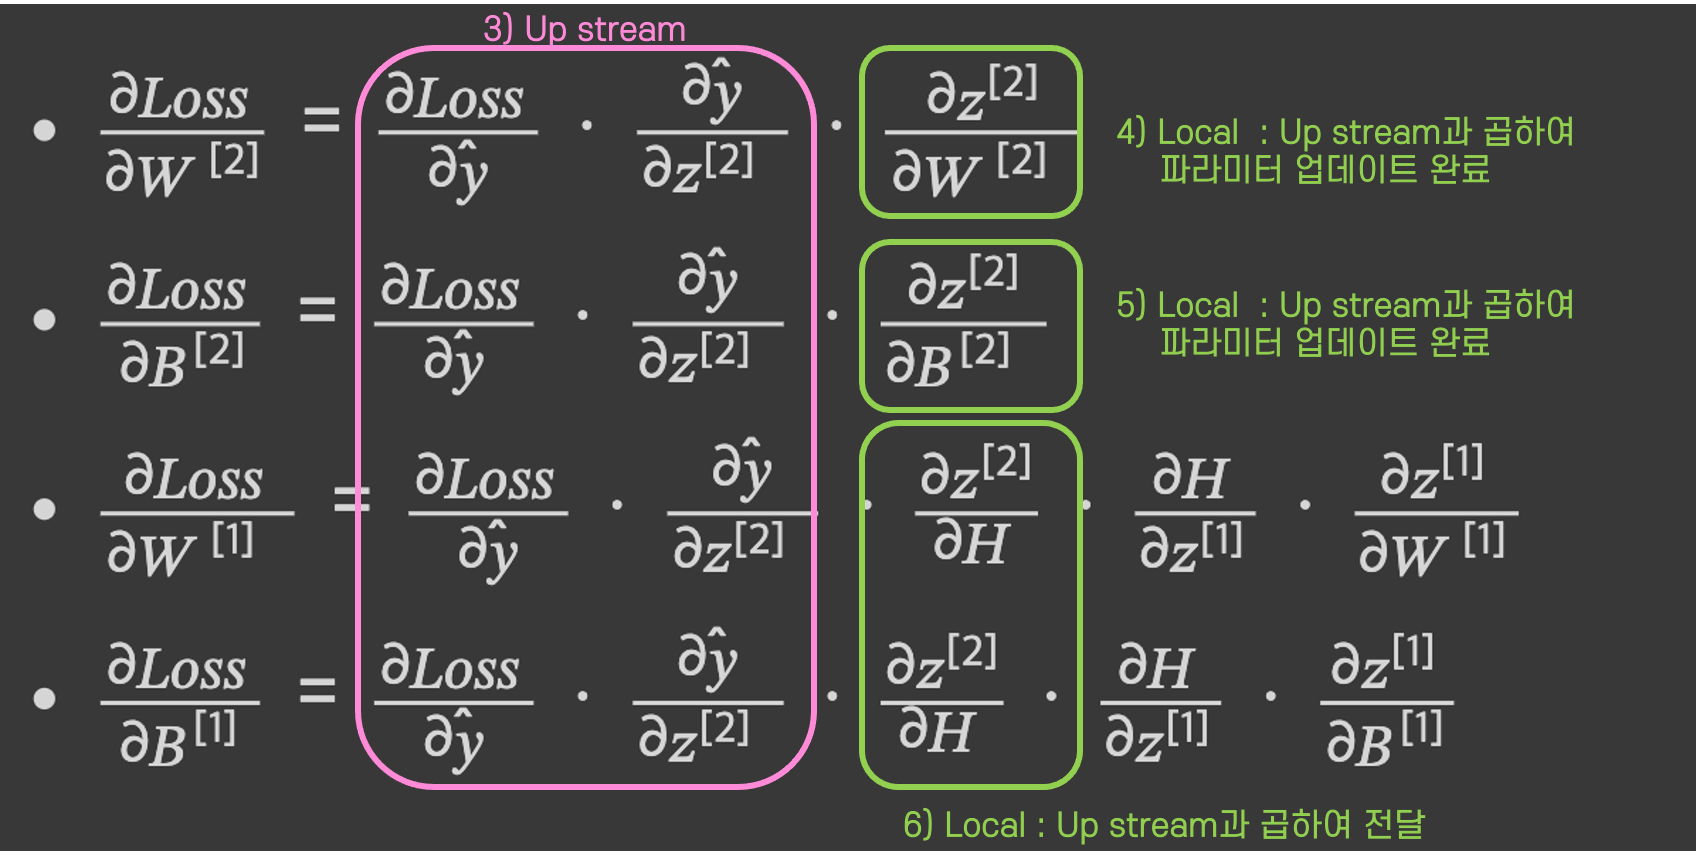

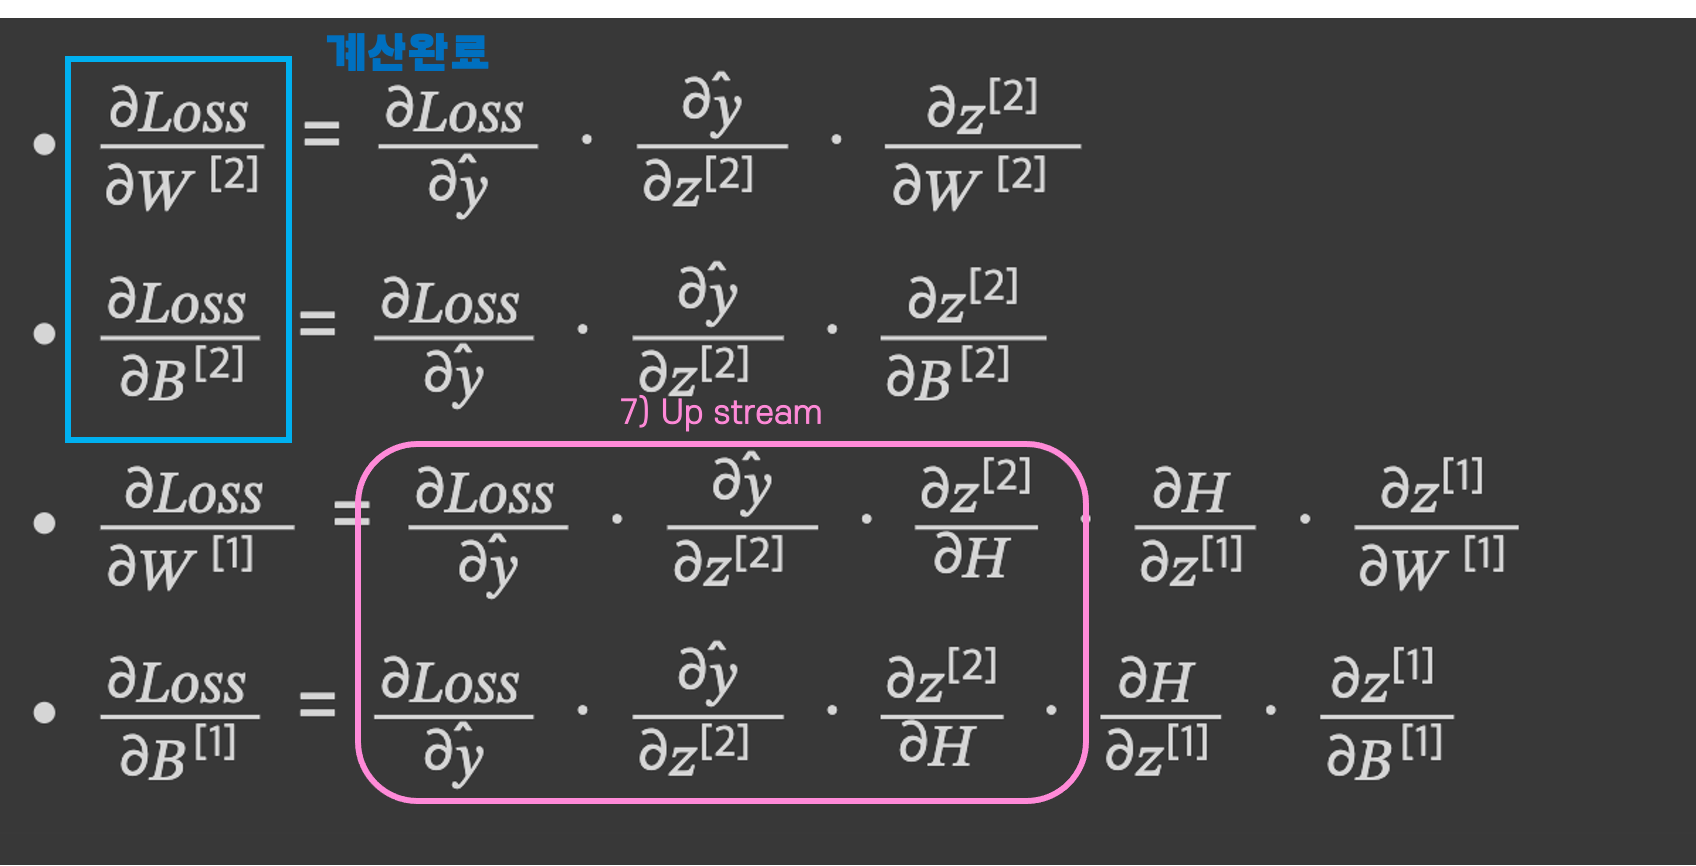

이제 첫번째 레이어 연산의 파라미터 편미분만 남았습니다. $\frac{\partial Loss}{\partial W^{[1]}}$과 $\frac{\partial Loss}{\partial B^{[1]}}$ 구하는 방법은 이전의 방밥과 같습니다. 아래의 수식 그림을 참고해주세요. <br><br>

**8) 첫번째 레이어 활성화 함수(시그모이드) 편미분 `8)Local` gradient $\frac{\partial H}{\partial z^{[1]}}$을 계산합니다.**

**9) 이를 이전의 `7)Up stream` gradient와 곱하여 새로운 `9)Up stream` gradient를 만들고**

**10) 첫번째 레이어 어파인함수 각각의 편미분 `10) Local, 11)Local` gradient $\frac{\partial z^{[1]}}{\partial W^{[1]}}$, $\frac{\partial z^{[1]}}{\partial B^{[1]}}$을 `9)Up stream` gradient와 곱하여 $\frac{\partial Loss}{\partial W^{[1]}}$과 $\frac{\partial Loss}{\partial B^{[1]}}$계산을 완료합니다.**

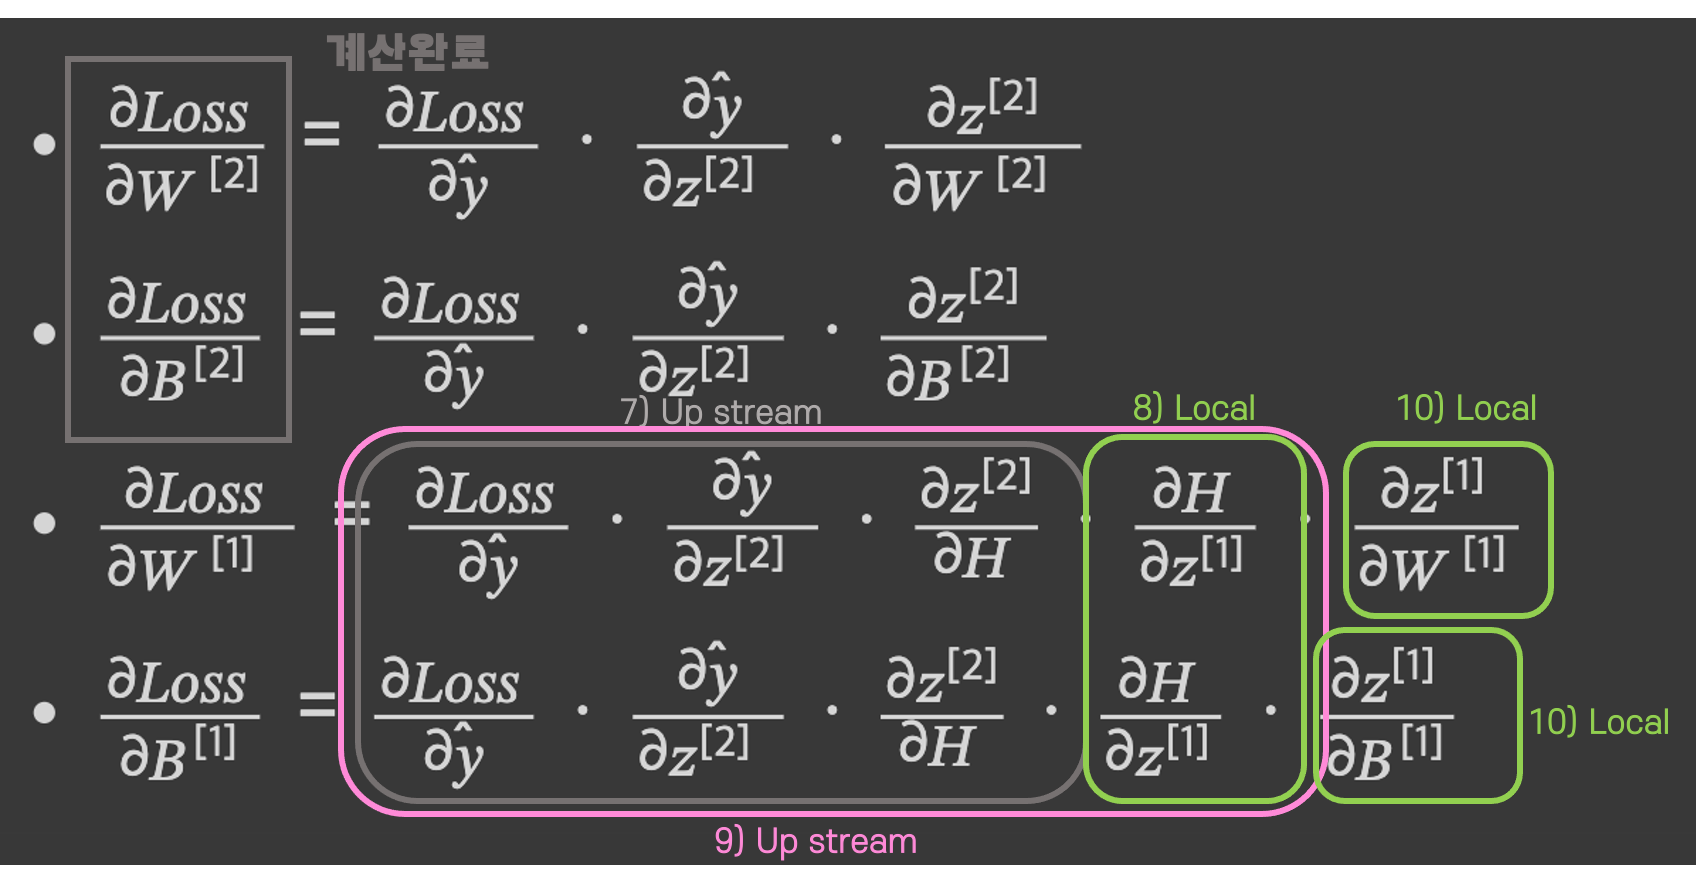

이제부터 XOR 연산의 역전파 과정을 코드를 이용하여 구현해 보겠습니다.

### 2레이어 뉴럴네트워크의 역방향 그레디언트 계산하기

전체 과정을 쉽게 이해하기 위해서는 그림과 함께 보는것이 좋습니다. 조금 복잡해 보일 수 있지만 하나하나 따라가다보면 이해하실 수 있을 것 입니다. 그림은 이전과 마찬가지로 최우성님의 블로그 [Multi-Layer Neural Network](https://ws-choi.github.io/blog-kor/deeplearning/Multi-Layer-Neural-Network/#)에서 가져온 온 후 그곳에 역전파 연산 순서대로 번호를 추가하였습니다.

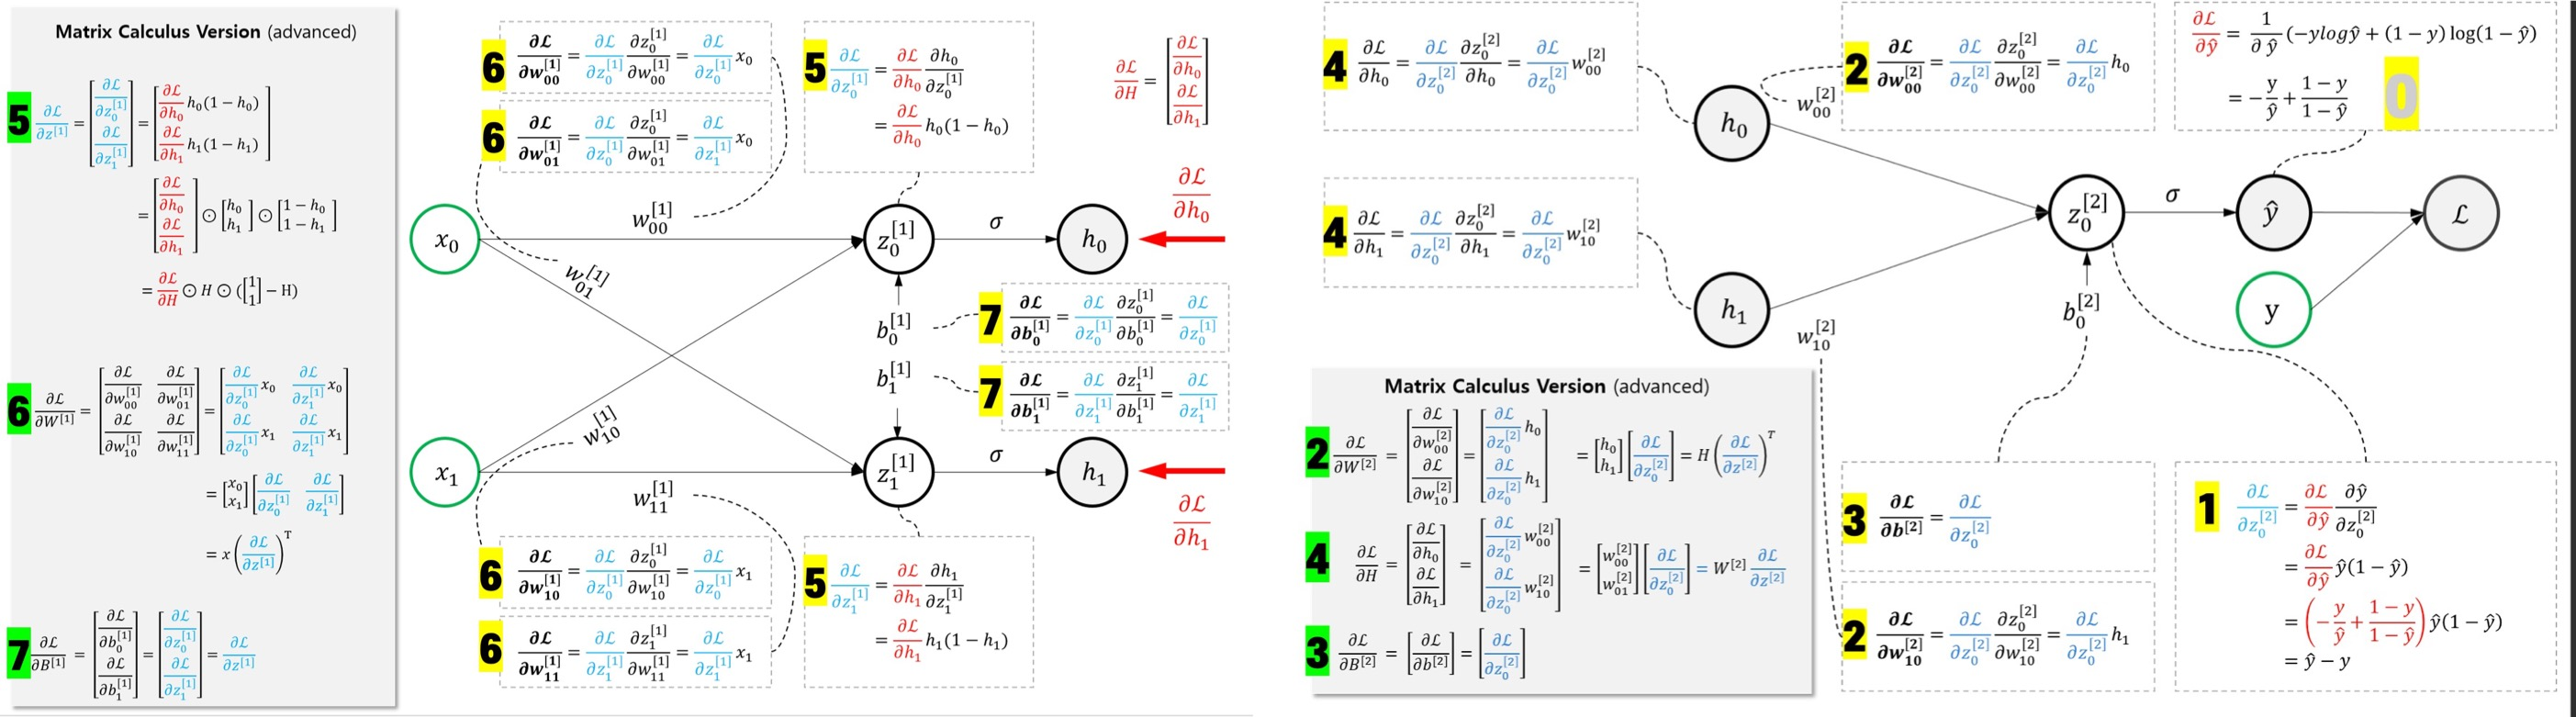

역전파 과정은 위 그림의 오른쪽 상단에 위치한 손실함수의 미분인 `0`번에서 시작합니다. 이제 시그모이드 편미분인 Local gradient와 곱해져서 위 그림의 `1`이 계산됩니다. `1`의 결과는 재밌게도 $\hat y - y$이네요. 추정값과 정답의 차이가 Up stream gradient가 되어서 전달되는 것을 알 수 있습니다. 둘의 차이가 크면 큰 값이 최종 파라미터 편미분에 영향을 줄것이고 작다면 작은 영향을 줄것이란 것을 짐작해볼 수 있습니다.

이제 위 그림의 `2` 연산을 수행해야 하는데요, 여기서부터는 미션으로 여러분이 구현할 차례 입니다.

위 그림에서 `노란색`의 번호는 각 변수의 요소별 편미분결과를 의미하고 이를 행렬 형태의 편미분으로 한번에 표현한 것이 `초록색` 동일한 번호 입니다. 실제 구현을 위해서는 `초록색` 번호를 구현하시면 쉽게 역전파 과정이 구현될 것 입니다.

In [ ]:
######################################
####### 미션 코드 : 역전파 구현하기 ##########
######################################

def get_gradients(X, Y, _params):
  W1, B1, W2, B2 = _params
  m = X.shape[1] # 샘플의 수
  # 포워드 함수 통과 후 출력
    # - Z1 : 첫번재 레이어 affine 결과
    # - H : 첫번재 레이어 sigmoid 통과한 결과
    # - Z2 : 두번재 레이어 affine 통과한 결과
    # - YHat : 두번재 레이어 sigmoid 통과한 결과
    # - loss : 크로스엔트로피 손실값
  Z1, H, Z2, YHat, loss = forward_loss(X, Y, _params)

  # 1) dLoss/dZ2 구현. 손실함수가 각 샘플 손실의 평균으로 계산되기 때문에 그대로 구현하였습니다.
  dLdZ2 = (1/m)*(YHat-Y) # 그림에서 1의 구현

  # 2) dLoss/dW2의 구현 - '...'을 구현하세요.
  dLdW2 = ... # 그림에서 2의 구현 (초록색 2번 참고)

  # 3) dLoss/dB2의 구현 - 샘플마다 gradient가 있음. 따라서 합쳐줘야 함.
  dLdB2 = np.sum(dLdZ2, axis=1, keepdims=True) # 그림에서 3의 구현

  # 4) dLoss/dH의 구현 - '...'을 구현하세요.
  dLdH = ... #  그림에서 4의 구현

  # 5) dLoss/dZ1의 구현 - '...'을 구현하세요.
  dLdZ1 = ... # 그림에서 5의 구현

  # 6) dLoss/dW1의 구현 - '...'을 구현하세요.
  dLdW1 = ... # 그림에서 6의 구현

  # 7) dLoss/dB2의 구현 - '...'을 구현하세요.
  dLdB1 = ...

  return [dLdW1, dLdB1, dLdW2, dLdB2], loss

함수를 잘 구현하셨나요? ^^

지금까지 구현한 순방향과 역방향 연산을 살펴보면 모두 배치 처리가 가능한 형태임을 알수 있습니다. 즉 행렬 연산의 특성으로 인해 여러 개의 입력을 순방향으로 보내면 여러개의 출력 결과를 얻을 수 있게 됩니다.

역방향으로 그레디언트를 계산할 때도 마찬가지 입니다. 가중치 $W$의 여러개의 샘플별 그레디언트는 `np.dot`을 수행할 때 합쳐지고 바이어스 $B$에 대한 그레디언트는 `np.sum`으로 합쳐집니다.

배치처리로 인하여 빠른 처리가 학습이 가능해질 수 있습니다.



### 학습하기

경사하강법을 구현하기 위해 `optimize`라는 함수를 만들었습니다.

In [ ]:
def optimize (X, Y, _params, learning_rate = 0.1, iteration = 1000):

    params = np.copy(_params) # 파라미터 복사
    loss_trace = [] # 손실 값 저장

    for epoch in range(iteration): # 학습 반복
        dparams, loss = get_gradients(X, Y, params) # 그레디언트 추출
        for param, dparam in zip(params, dparams):
            param += - learning_rate * dparam # 경사하강법 구현

        if (epoch % 100 == 0): # 손실값 저장
            loss_trace.append(loss)

    _, _, _, Y_hat_predict, _ = forward_loss(X, Y, params) # 학습된 모델로 추론

    return params,loss_trace, Y_hat_predict

이제 XOR 입력과 정답을 다시 써보고 모델을 학습시켜 보겠습니다.


In [ ]:
X = np.array([0, 0, 1, 1, 0, 1, 0, 1]).reshape(2,4) # 입력
Y = np.array([0, 1, 1, 0]).reshape(1,4) # 정답

params = init_parameters(2) # 파라미터 세팅
new_params, loss_trace, Y_hat_predict = optimize(X, Y, params, 0.1, 150000) # 학습 및 추론

print(Y_hat_predict) # 정답 Y와 유사한 값이 나왔다면 학습이 잘 진행된 것 입니다.

다음은 학습이 진행된 동안 저장되었던 손실함수의 값을 출력해보도록 하겠습니다.

In [ ]:
import matplotlib.pyplot as plt

# Plot learning curve (with costs)
plt.plot(loss_trace)
plt.ylabel('loss')
plt.xlabel('iterations (per hundreds)')
plt.show()

ALL RIGHTS RESERVED. (C)NAVER Connect Foundation.